In [11]:
from lesson3Code.pokemonTournament.pokemonDef import Monster,superEffective,notEffective,noEffect
import lesson3Code.pokemonTournament.pokemonFunctions as pf
import sys, random, time, math, pickle, pdb
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

Modelling
- first hour
    - experimentral alg
    - pipeline
    - examples
    - homework
- second hour
    - pokemon
    - intro I.P

ゴール： 現実的な問題をコンピュータの能力内で解く  
JEA SEAなどのコミュニティサイトがある.  
論文をまとめてあるサイト？gatech?なども使える．  
アルゴリズムを論文に乗せるのに大事なこと，実験に大事なこと？  
コードを見せることではなく，問題がなんなのか，その解法の長所と短所はなんなのか，にたいする洞察を示すことが大事である．  

# EA pipeline Step  
<br>
<div style="text-align:center">problem(client) -> formalization -> algorithm design -> implementation -> experimentation</div>
<br>
この一連のステップそれぞれからPractical Insightを導き，さらにFeedbackを付け加える  
homeworkはexperimentationの辺りから何か出される

## Formalization
needs storong mathematical foundations  
理論上重要なことが実践では重要ではないことがある．  
Bias filtering vs Approximation algorithm

## Algorithm design
どんな点でBest solutionなのか?(最適解を出せるのか，早いのか)  
実装時に発生する問題を考慮してデザインすることが大事

## Implementation
Programming language, team, task distribution...  
専門知識なしで，誰が実装しても良いようにしたい．  
実装時間 vs 実行時間

## Experiments
実験の設計(何をどうやって測定するのか)を定める  
実験時の「バイアス」に注意する  
- 認証バイアス(confirmation bias)世の中で正しいとされているもの，正しいと自分が信じているものを正しいとしてしまうこと
- 文化バイアス(culture bias)メディアなど？

## Insight
- 洞察の種類(問題，アプローチ)
    - 結果の解釈
    - 仮説検証
- SOFT skills

# Practical Examples
- road network matching
- medical image analysis
- 3D point set residues

## Road network matching
地図の一部がどこのものであるかを調べる  
交差点と交差点への彩色問題によって，$O(n^4 n'^{3} \log n')$で解ける. YAGO先生の論文より

## Medical Image Analysis

## 3D Point Cloud Matching
複数の角度から撮ったうさぎの3Dモデルができるって話  
最低3つの同じ位置にある点を見つける必要がある．  $O(n^6)$  
最新では$O(n^2)$くらい？
最悪計算量のオーダが多くても，現実のデータで例えば全てのなんらかの対象となるピクセルがある領域に固まっていることはないなどの仮定を置けば有用なアルゴリズムとなる．

# Toy Problem
which is the strongest Pokemon?
Formalization
- how many pokemon are there?
    251? FIRST GENERATION Pokemons.
- what does "strong" mean?
    winners of Combats
- read bibliograohy
    - 参考：https://hubpages.com/entertainment/Top-10-Strongest-First-Generation-Pokemons

Algorithm design
- combat system はユーザのコマンドを必要とする
- タイプシステム
- Moves can be developed using points during the game
- Official codeを入手することはできない

## Implementation
easy to implement  
no money  
python  

Home work
1. review the python code, feel free to improve it.
2. design experiment(s) to find out the stronger pokemon and pokemon team
    team: 6 pokemon, 1匹ずつ戦い，勝ったほうが次のポケモンと戦う
3. Report
    - results/comments insight!
    - Given the restrictions, how would you improve the process(Formalization, design, implementation)
    - restrictionsがなければどうやってimproveするか？
    - 結果は予想どうりのものか？そうでなければ何が問題だったのか
    - もうなんかよくわかんないので，最強のポケモンとポケモンチームを得るために何をやったのかまとめて，あと最後にちょっとした考察を付け加えることにする

# Preparation

In [3]:
listOfNamesAndTypes=pf.readPokemonTypesFromFile("lesson3Code/pokemonTournament/listOfPokemon1.txt")
pokeList=pf.readPokemonListFromFile("lesson3Code/pokemonTournament/listOfPokemon2.txt")

pokedex={}
for monster in pokeList:
    pokedex[monster.name]=monster

for name,listOfTypes in listOfNamesAndTypes:
    for t in listOfTypes:
        pokedex[name].variety.append(t)

# Who is the strongest Pokemon?
とりあえず思いつくのは総当たり戦をして，勝った回数が一番多いやつが強い  
(より早くしたいならランダムリーグ戦をやらせるという手もあるが，これは最強とは言えず，またポケモンの数がそんなに多くないので総当たりで正確性を求めても問題ない．)

In [4]:
# Numpy arrayの各行に名前を付ける練習
a = np.array([(1,3), (3,2), (3,1)], dtype=[('x', 'i'), ('y', 'i')])
print(a['x'])
print(a['x'].argmax())
print(a['x'].argsort())
print(a['y'].argsort())
print(a.argsort(order=['x', 'y'])) # sort by x then y

[1 3 3]
1
[0 1 2]
[2 1 0]
[0 2 1]


In [20]:
z = np.zeros(10, dtype=[('w','i'), ('l', 'i'), ('d', 'i')])
z['w']

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [22]:
def SingleRoundRobinExperiment(p, enemy_list=pokeList, k=1, battle=pf.battle, skip_same=False, verbose=False):
    results = np.zeros(len(enemy_list), dtype=[('w','i'), ('l', 'i'), ('d', 'i')]) # win, loss, draw
    for idx, enemy in enumerate(enemy_list):
        if skip_same and p.name == enemy.name: continue
        for i in range(k):
            result = battle(p, enemy)
            if result == 0: results[idx]['w'] += 1
            elif result == 1: results[idx]['l'] += 1
            else: results[idx]['d'] += 1
    return results

In [23]:
def RoundRobinExperiment(k=1, battle=pf.battle, verbose=False):
    get_result = lambda p: SingleRoundRobinExperiment(p, k=k, battle=battle, verbose=verbose)
    results = np.array([get_result(p) for p in pokeList]) # battles results win-loss-draw, the indices represents pokemon indices

    if verbose:
        ranking = results['w'].sum(axis=0).argsort()
        strongest = pokeList[ranking[0]]
        print("The strongest pokemon is", strongest.name, "id:", strongest.index)
        print("The strongest pokemon parameter", strongest)
        print("Strongest Pokemon Top 10")
        for i in ranking[:10]:
            print(pokeList[i])
    
    return results

総当たり: $O(n^2)$  
$K$回の総当たり: $O(Kn^2)$  
この場合は，「あるポケモンが自分より弱いポケモンが何種類いるか」が強さの基準になっている．  
- 長所
    - ポケモンの能力値がわからなくても強さを測定できる．
    - 実装が簡単である
- 短所
    - 時間がかかる
    - Combat Systemに乱数(一様分布)が利用されているため,実験の度に結果が変わる
        - 何回繰り返したところで最強とは限らない

In [60]:
K = 100

try:
    raise Exception # For creating new pickle data
    with open('data/normal_result.pkl', 'rb') as f:
        normal_result = pickle.load(f)
        print('normal result is loaded from the pickle file')
except:
    normal_result = RoundRobinExperiment(K, verbose=True)
    with open('data/normal_result.pkl', mode='wb') as f:
        pickle.dump(normal_result, f)
finally:
    normal_ranking = [pokeList[p] for p in normal_result['w'].sum(axis=0).argsort()]

The strongest pokemon is Cloyster id: 90
The strongest pokemon parameter Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 50], variety=['Water', 'Ice'])
Strongest Pokemon Top 10
Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 50], variety=['Water', 'Ice'])
Monster(name='Dragonite', index=148, attack=134, defense=95, speed=100, hitpoint=[91, 74], variety=['Dragon', 'Flying'])
Monster(name='Rhydon', index=111, attack=130, defense=120, speed=45, hitpoint=[105, 100], variety=['Ground', 'Rock'])
Monster(name='Kingler', index=98, attack=130, defense=115, speed=50, hitpoint=[55, 55], variety=['Water'])
Monster(name='Golem', index=75, attack=110, defense=130, speed=55, hitpoint=[80, 73], variety=['Rock', 'Ground', 'Electric'])
Monster(name='Gyarados', index=129, attack=125, defense=79, speed=100, hitpoint=[95, -3], variety=['Water', 'Flying'])
Monster(name='Mewtwo', index=149, attack=110, defense=90, speed=154, hitpoint=[106,

## Speed Battle
pf.battleは遅い．  
総当たりで時間がかかっているところを見たら，ダメージ0を与えあっているやつらが1000ターン消費してdrawになっていた．  
なのでmax_roundは100にしておいた．  
それでも，パラメータだけを見ればバトルの結果がおおよそわからないだろうか  
そこで，乱数による変動値を期待値に置き換え，理論上何ターン生き残れるかの差で勝負を決めさせてみる

Speed Battleは次の仮説に基づいて勝敗が決まる
- 同じタイプの場合，攻撃力，防御力，HPで力関係の期待値がわかる
    - 毎ターンそれぞれが対決
    - 攻撃力と防御力の変動値は同じタイプであれば一様分布で決まる

In [69]:
def SpeedBattle(p1, p2, resetHP=True, verbose=False):
    effectiveness = 0.3
    max_rounds = 1000
    
    if resetHP:
        pf.ResetHP(p1)
        pf.ResetHP(p2)
    
    if noEffect(p1, p2) and noEffect(p2, p1): return 2
    elif noEffect(p1, p2): return 1
    elif noEffect(p2, p1): return 0
    
    attackCenter1=1
    if superEffective(p1, p2): attackCenter1+=effectiveness
    elif notEffective(p1, p2): attackCenter1-=effectiveness

    attackCenter2=1
    if superEffective(p2, p1): attackCenter2+=effectiveness
    elif notEffective(p2, p1): attackCenter2-=effectiveness
    
    get_damage1 = max(0, (round(p2.attack * attackCenter2) - round(p1.defense * 0.9)))
    survive_rounds1 = (p1.hitpoint[1] / get_damage1) if get_damage1 > 0 else max_rounds
        
    get_damage2 = max(0, (round(p1.attack * attackCenter1) - round(p2.defense * 0.9)))
    survive_rounds2 = (p2.hitpoint[1] / get_damage2) if get_damage2 > 0 else max_rounds
        
    if survive_rounds1 == survive_rounds2: 
        if survive_rounds1 == max_rounds: return 2
        if p1.speed == p2.speed: return 2
        return 0 if p1.speed > p2.speed else 1
    
    return 0 if survive_rounds1 > survive_rounds2 else 1

In [70]:
# The result is deterministic. So it is enough for k to be 1.
speed_result = RoundRobinExperiment(battle=SpeedBattle, verbose=True)
speed_ranking = [pokeList[p] for p in speed_result['w'].sum(axis=0).argsort()]

The strongest pokemon is Cloyster id: 90
The strongest pokemon parameter Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 50], variety=['Water', 'Ice'])
Strongest Pokemon Top 10
Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 50], variety=['Water', 'Ice'])
Monster(name='Kingler', index=98, attack=130, defense=115, speed=50, hitpoint=[55, 55], variety=['Water'])
Monster(name='Gyarados', index=129, attack=125, defense=79, speed=100, hitpoint=[95, 95], variety=['Water', 'Flying'])
Monster(name='Dragonite', index=148, attack=134, defense=95, speed=100, hitpoint=[91, 91], variety=['Dragon', 'Flying'])
Monster(name='Mew', index=150, attack=100, defense=100, speed=100, hitpoint=[100, 100], variety=['Psychic'])
Monster(name='Mewtwo', index=149, attack=110, defense=90, speed=154, hitpoint=[106, 106], variety=['Psychic'])
Monster(name='Slowbro', index=79, attack=75, defense=110, speed=80, hitpoint=[95, 95], variety=['Water', 'P

どれくらい高速化できたのか？

In [71]:
startNormal = time.time()
RoundRobinExperiment() # 8 sec when max round was 1000
endNormal = time.time()
print("Normal Battle Elapsed Time:", endNormal - startNormal)

startSpeed = time.time()
RoundRobinExperiment(battle=SpeedBattle)
endSpeed = time.time()
print("Speed Battle Elapsed Time:", endSpeed - startSpeed)

Normal Battle Elapsed Time: 1.603743553161621
Speed Battle Elapsed Time: 0.3001692295074463


大体5倍くらい早くなった．  
max roundを1000にすれば20倍くらい違う．  
では肝心の精度はどうだろうか？

In [72]:
normal_ranking_id = np.array([p.index for p in normal_ranking]) 
speed_ranking_id = np.array([p.index for p in speed_ranking])
same_places = normal_ranking_id == speed_ranking_id
print(f"same places: {sum(same_places)} / {len(same_places)}")

same places: 10 / 151


ピッタリ賞の数を調べてみると，ほとんど合っていない．  
順位が同じ，という基準では少し厳しい気がするので，レーベンシュタイン距離を基準にしてみる．

In [42]:
# Levenstein Distance by Dynamic Programming
def LevensteinDistance(l1, l2):
    len1 = len(l1) + 1
    len2 = len(l2) + 1
    
    dp = np.zeros((len1, len2), dtype='i')
    for row in range(len1): dp[row][0] = row
    for col in range(len2): dp[0][col] = col
        
    for row in range(1, len1):
        for col in range(1, len2):
            c = 0 if l1[row-1] == l2[col-1] else 1
            dp[row][col] = min(dp[row-1][col]+1, dp[row][col-1]+1, dp[row-1][col-1] + c)

    return dp[-1][-1]

In [73]:
LevensteinDistance(normal_ranking_id, speed_ranking_id)

120

やってみたものの，レーベンシュタイン距離でもその成果はよくわからない．  
次に，10位以内に入っているポケモンの組み合わせがどれだけ合っているかを調べてみる

In [74]:
print("========== Normal : Speed ==========")
normal_top_10 = normal_ranking[:10]
for p in speed_ranking[:10]:
    print(f"{p.name} is {'IN the' if p in normal_top_10 else 'out of'} normal ranking top 10")

========== Normal : Speed ==========
Cloyster is IN the normal ranking top 10
Kingler is IN the normal ranking top 10
Gyarados is IN the normal ranking top 10
Dragonite is IN the normal ranking top 10
Mew is IN the normal ranking top 10
Mewtwo is IN the normal ranking top 10
Slowbro is out of normal ranking top 10
Weezing is out of normal ranking top 10
Zapdos is IN the normal ranking top 10
Pinsir is out of normal ranking top 10


7/10, 10位以内に入っているかどうかの基準では，結構よさそう．  
<br>
どうやら実際の順位とのズレはあまりなさそう．  
実際の順位との距離の相場，すなわち順位の二乗誤差を取ってみる．  

In [75]:
def std_rank_error(ranking):
    normal_ranking_list = list(normal_ranking)
    ranking_error = []
    for rank, p in enumerate(ranking):
        ranking_error.append((normal_ranking_list.index(p) - rank) ** 2)

    return math.sqrt(sum(ranking_error) / len(ranking_error))

print("Standard Rank Error:", std_rank_error(speed_ranking))

Standard Rank Error: 9.194008990886582


順位のズレの相場は9位．結構大きい．

In [83]:
print("Standard Rank Error Over Mid:", std_rank_error(speed_ranking[:75]))
print("Standard Rank Error Under Mid:", std_rank_error(speed_ranking[75:]))

Standard Rank Error Over Mid: 11.026634421557045
Standard Rank Error Under Mid: 75.12226875672683


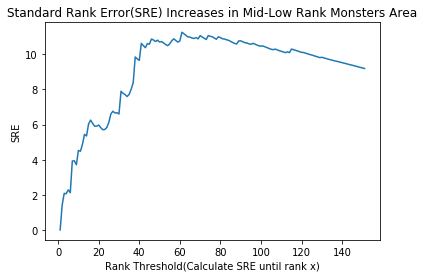

In [88]:
x = range(1, len(pokeList) + 1)
y = [std_rank_error(speed_ranking[:r]) for r in x]
plt.plot(x,y)
plt.title("Standard Rank Error(SRE) Increases in Mid-Low Rank Monsters Area")
plt.xlabel("Rank Threshold(Calculate SRE until rank x)")
plt.ylabel("SRE")
plt.show()

このことから，順位の低いモンスターでSpeedバトルの結果がズレていることが分かる．  
そもそも弱いポケモンは運で勝敗が決まるため，順位が前後しやすい．  
一方で．強いポケモンはその地位を保ち続けやすいことが分かる．  
つまり，最弱王決定戦をSpeedBattleでやろうとするとなかなか正しい答えは出にくいが，最強決定戦をSpeedBattleでやっても誤差は出にくいということが分かる．  
SpeedBattleを行ううえではこういった性質を理解しておくと良い．

# Why Cloyster is so strong?
Let us check the status of Cloyster.

In [89]:
strongest = normal_ranking[0]
print(strongest)

max_attack = max([p.attack for p in pokeList])

print("Enemy of Cloyster at leaste needs to be SuperEffective variety, because max_attack * 1.2 = ", max_attack * 1.2, "<", strongest.defense)

Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 50], variety=['Water', 'Ice'])
Enemy of Cloyster at leaste needs to be SuperEffective variety, because max_attack * 1.2 =  160.79999999999998 < 180


In [90]:
print("Pokemon Defense Ranking")
defense_ranking = np.argsort([p.defense for p in pokeList])[::-1]
for p in defense_ranking[:10]:
    print(pokeList[p])

Pokemon Defense Ranking
Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 50], variety=['Water', 'Ice'])
Monster(name='Onix', index=94, attack=45, defense=160, speed=30, hitpoint=[35, 35], variety=['Rock', 'Ground'])
Monster(name='Golem', index=75, attack=110, defense=130, speed=55, hitpoint=[80, 80], variety=['Rock', 'Ground', 'Electric'])
Monster(name='Omastar', index=138, attack=60, defense=125, speed=115, hitpoint=[70, 70], variety=['Rock', 'Water'])
Monster(name='Weezing', index=109, attack=90, defense=120, speed=85, hitpoint=[65, 65], variety=['Poison'])
Monster(name='Rhydon', index=111, attack=130, defense=120, speed=45, hitpoint=[105, 105], variety=['Ground', 'Rock'])
Monster(name='Graveler', index=74, attack=95, defense=115, speed=45, hitpoint=[55, 55], variety=['Rock', 'Ground', 'Electric'])
Monster(name='Kingler', index=98, attack=130, defense=115, speed=50, hitpoint=[55, 55], variety=['Water'])
Monster(name='Tangela', index=113, attack=55, d

In [91]:
print("Pokemon Attack Ranking")
attack_ranking = np.argsort([p.attack for p in pokeList])[::-1]
for p in attack_ranking[:10]:
    print(pokeList[p])

Pokemon Attack Ranking
Monster(name='Dragonite', index=148, attack=134, defense=95, speed=100, hitpoint=[91, 91], variety=['Dragon', 'Flying'])
Monster(name='Rhydon', index=111, attack=130, defense=120, speed=45, hitpoint=[105, 105], variety=['Ground', 'Rock'])
Monster(name='Kingler', index=98, attack=130, defense=115, speed=50, hitpoint=[55, 55], variety=['Water'])
Monster(name='Machamp', index=67, attack=130, defense=80, speed=65, hitpoint=[90, 90], variety=['Fighting'])
Monster(name='Flareon', index=135, attack=130, defense=60, speed=110, hitpoint=[65, 65], variety=['Fire'])
Monster(name='Pinsir', index=126, attack=125, defense=100, speed=55, hitpoint=[65, 65], variety=['Bug'])
Monster(name='Gyarados', index=129, attack=125, defense=79, speed=100, hitpoint=[95, 95], variety=['Water', 'Flying'])
Monster(name='Hitmonlee', index=105, attack=120, defense=53, speed=35, hitpoint=[50, 50], variety=['Fighting'])
Monster(name='Kabutops', index=140, attack=115, defense=105, speed=70, hitpoint

そもそもCloysterの防御が強すぎて，攻撃を通せるやつがほとんどいないことが分かる．  
<br>
では，だれがCloysterに対抗できるのだろうか．  
Cloysterに攻撃を通せる奴がどれだけいるかを調べてみる．  
まずは最低どれだけの攻撃力が必要かを調べる．

In [95]:
round(180 * 0.7)

126

Effective pokemons should have attack > 126  
Or who have varieties against Water and Ice are...
- Grass
- Electric
- Fighting
- Rock
- Steel

and have enough attack

In [96]:
effective_varieties = ['Grass', 'Electric', 'Fighting', 'Rock', 'Steel']
effective_pokeList = [p for p in pokeList if np.any([v in p.variety for v in effective_varieties]) or p.attack > 126]
print("# of Pokemons who can fight Cloyster:", len(effective_pokeList), "/", len(pokeList))

winnable_pokeList = [p for p in effective_pokeList if p.attack * 1.3 * 1.2 > 180 * 0.7]
print("\n# of Pokemons who can give a damage to Cloyster:", len(winnable_pokeList), "/", len(pokeList))

for p in winnable_pokeList:
    print(p)

# of Pokemons who can fight Cloyster: 49 / 151

# of Pokemons who can give a damage to Cloyster: 24 / 151
Monster(name='Venusaur', index=2, attack=82, defense=83, speed=100, hitpoint=[80, 0], variety=['Grass', 'Poison'])
Monster(name='Raichu', index=25, attack=90, defense=55, speed=90, hitpoint=[60, -36], variety=['Electric', 'Psychic'])
Monster(name='Sandslash', index=27, attack=100, defense=110, speed=55, hitpoint=[75, -8], variety=['Ground', 'Steel'])
Monster(name='Parasect', index=46, attack=95, defense=80, speed=80, hitpoint=[60, -23], variety=['Bug', 'Grass'])
Monster(name='Primeape', index=56, attack=105, defense=60, speed=60, hitpoint=[65, -25], variety=['Fighting'])
Monster(name='Poliwrath', index=61, attack=85, defense=95, speed=70, hitpoint=[90, 37], variety=['Water', 'Fighting'])
Monster(name='Machoke', index=66, attack=100, defense=70, speed=50, hitpoint=[80, -5], variety=['Fighting'])
Monster(name='Machamp', index=67, attack=130, defense=80, speed=65, hitpoint=[90, 19], v

Cloysterに立ち向かう選ばれしポケモンたちを実際に戦わせてみて，どのポケモンが一番Cloysterに有効なのかを調べてみる

In [98]:
k = 100
cloyster = pokedex["Cloyster"]
challengers = winnable_pokeList

win_times = np.zeros(len(challengers), dtype='i')
for i, challenger in enumerate(challengers):
    for _ in range(k):
        if pf.battle(challenger, cloyster) == 0: 
            win_times[i] += 1
            
ranking = win_times.argsort()[::-1]
for idx in ranking:
    print(f"Challenger {challengers[idx].name} Win Rate: {win_times[idx]}/{k}")

Challenger Rhydon Win Rate: 73/100
Challenger Machamp Win Rate: 43/100
Challenger Golem Win Rate: 13/100
Challenger Dragonite Win Rate: 5/100
Challenger Hitmonlee Win Rate: 1/100
Challenger Flareon Win Rate: 0/100
Challenger Weepinbell Win Rate: 0/100
Challenger Raichu Win Rate: 0/100
Challenger Sandslash Win Rate: 0/100
Challenger Parasect Win Rate: 0/100
Challenger Primeape Win Rate: 0/100
Challenger Poliwrath Win Rate: 0/100
Challenger Machoke Win Rate: 0/100
Challenger Aerodactyl Win Rate: 0/100
Challenger Victreebel Win Rate: 0/100
Challenger Electabuzz Win Rate: 0/100
Challenger Graveler Win Rate: 0/100
Challenger Zapdos Win Rate: 0/100
Challenger Kingler Win Rate: 0/100
Challenger Exeggutor Win Rate: 0/100
Challenger Hitmonchan Win Rate: 0/100
Challenger Rhyhorn Win Rate: 0/100
Challenger Kabutops Win Rate: 0/100
Challenger Venusaur Win Rate: 0/100


この結果からわかるように，パルシェンにはサイドンをぶつけるのが有効である．  
ちなみにSpeedBattleのようにパラメータで勝負させるとみんな負ける．

## If we know the enemy Pokemon
一番勝率の高いポケモンをぶつける

In [106]:
def natural_enemies(p, enemy_list=pokeList, k=10, ranking=normal_ranking, battle=pf.battle, top=6, verbose=False):
    results = SingleRoundRobinExperiment(p, k=k, enemy_list=enemy_list, battle=battle, verbose=verbose)
    loss_times = results['l']
    
    # Higher possibility of loss, and then higher ranking
    id_ranking = [p.index for p in ranking]
    
    # the index is pokeID, and has negative loss_time and rank
    loss_times = np.array([(-loss_time, id_ranking.index(idx)) for idx, loss_time in enumerate(loss_times)], dtype=[('l', 'i'), ('r', 'i')])
    
    # firstly, order by negative loss_time, secondly, by ranking
    strongest_natural_enemy_ids = loss_times.argsort(order=['l', 'r'])[:top]
        
    if verbose:
        print(f"{p.index}. Natural Enemies to {p.name}")
        for idx, i in enumerate(strongest_natural_enemy_ids):
            print(f"{idx+1}. {pokeList[i].name}, loss-times: {-loss_times[i][0]} / {k}")
        print()

    return [pokeList[i] for i in strongest_natural_enemy_ids]

def natural_enemies_list(plist=pokeList, enemy_list=pokeList, k=10, ranking=normal_ranking, battle=pf.battle, top=6, verbose=False):
    return [natural_enemies(p, enemy_list=enemy_list, k=k, ranking=ranking, battle=battle, top=top, verbose=verbose) for p in plist]

In [126]:
try:
    # raise Exception # For creating new pickle file
    with open("data/natural_enemies_list.pkl", "rb") as f:
        ne_list = pickle.load(f)
        print("natural enemies list is loaded from pickle file")
except:
    ne_list = natural_enemies_list(k=100, verbose=False)
    with open("data/natural_enemies_list.pkl", "wb") as f:
        pickle.dump(ne_list, f)

natural enemies list is loaded from pickle file


In [135]:
k = 10000
loss_count = 0
ne_loss_list = []
for i in range(k):
    enemy_id = np.random.randint(len(pokeList))
    enemy = pokeList[enemy_id]
    natural_enemy = ne_list[enemy_id][0]
    result = pf.battle(natural_enemy, enemy, verbose=False)
    if result != 0:
        loss_count += 1
        ne_loss_list.append((natural_enemy, enemy))
        print("Natural Enemy Lose!")
        print("Natural Enemy:", natural_enemy)
        print('vs')
        print("Enemy:", enemy)
        print()

print(f"Natural Enemy Lose: {loss_count} times.")

Natural Enemy Lose!
Natural Enemy: Monster(name='Rhydon', index=111, attack=130, defense=120, speed=45, hitpoint=[105, -17], variety=['Ground', 'Rock'])
vs
Enemy: Monster(name='Rhydon', index=111, attack=130, defense=120, speed=45, hitpoint=[105, 46], variety=['Ground', 'Rock'])

Natural Enemy Lose!
Natural Enemy: Monster(name='Rhydon', index=111, attack=130, defense=120, speed=45, hitpoint=[105, -25], variety=['Ground', 'Rock'])
vs
Enemy: Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 41], variety=['Water', 'Ice'])

Natural Enemy Lose!
Natural Enemy: Monster(name='Kingler', index=98, attack=130, defense=115, speed=50, hitpoint=[55, -2], variety=['Water'])
vs
Enemy: Monster(name='Kingler', index=98, attack=130, defense=115, speed=50, hitpoint=[55, 25], variety=['Water'])

Natural Enemy Lose!
Natural Enemy: Monster(name='Dragonite', index=148, attack=134, defense=95, speed=100, hitpoint=[91, -91], variety=['Dragon', 'Flying'])
vs
Enemy: Monster(name='


Natural Enemy Lose!
Natural Enemy: Monster(name='Dragonite', index=148, attack=134, defense=95, speed=100, hitpoint=[91, -74], variety=['Dragon', 'Flying'])
vs
Enemy: Monster(name='Dragonite', index=148, attack=134, defense=95, speed=100, hitpoint=[91, 8], variety=['Dragon', 'Flying'])

Natural Enemy Lose!
Natural Enemy: Monster(name='Kingler', index=98, attack=130, defense=115, speed=50, hitpoint=[55, -9], variety=['Water'])
vs
Enemy: Monster(name='Kingler', index=98, attack=130, defense=115, speed=50, hitpoint=[55, 9], variety=['Water'])

Natural Enemy Lose!
Natural Enemy: Monster(name='Rhydon', index=111, attack=130, defense=120, speed=45, hitpoint=[105, -2], variety=['Ground', 'Rock'])
vs
Enemy: Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 35], variety=['Water', 'Ice'])

Natural Enemy Lose!
Natural Enemy: Monster(name='Rhydon', index=111, attack=130, defense=120, speed=45, hitpoint=[105, -14], variety=['Ground', 'Rock'])
vs
Enemy: Monster(name

天敵を充てても勝てないやつがいる．どいつか？

In [140]:
set([ne_loss_pair[0].name for ne_loss_pair in ne_loss_list])

{'Dragonite', 'Kingler', 'Rhydon'}

In [143]:
natural_enemies(pokedex['Dragonite'], k=100, verbose=True)

148. Natural Enemies to Dragonite
1. Dragonite, loss-times: 100 / 100
2. Rhydon, loss-times: 100 / 100
3. Golem, loss-times: 100 / 100
4. Cloyster, loss-times: 97 / 100
5. Kabutops, loss-times: 87 / 100
6. Graveler, loss-times: 83 / 100



[Monster(name='Dragonite', index=148, attack=134, defense=95, speed=100, hitpoint=[91, 62], variety=['Dragon', 'Flying']),
 Monster(name='Rhydon', index=111, attack=130, defense=120, speed=45, hitpoint=[105, 105], variety=['Ground', 'Rock']),
 Monster(name='Golem', index=75, attack=110, defense=130, speed=55, hitpoint=[80, 68], variety=['Rock', 'Ground', 'Electric']),
 Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 28], variety=['Water', 'Ice']),
 Monster(name='Kabutops', index=140, attack=115, defense=105, speed=70, hitpoint=[60, 34], variety=['Rock', 'Water']),
 Monster(name='Graveler', index=74, attack=95, defense=115, speed=45, hitpoint=[55, 48], variety=['Rock', 'Ground', 'Electric'])]

In [179]:
pf.battle(pokedex['Dragonite'], pokedex['Dragonite'], verbose=True)

Dragonite's ability is
	HP = [91, 91]
	attack = 134
	defense = 95
	speed = 100
	type = ['Dragon', 'Flying']
Dragonite's ability is
	HP = [91, 91]
	attack = 134
	defense = 95
	speed = 100
	type = ['Dragon', 'Flying']
Dragonite is super Effective against Dragonite
Dragonite is super Effective against Dragonite

Dragonite received 92 damage from Dragonite and has remaining HP -1

Dragonite wins the battle.


1

気づいてしまった．同じモンスターはHPを共有するので，相手に攻撃すると自分のHPも減ることになる．  
これはpf.battleの変更の必要がある．

# What is the strongest Pokemon team?
前提
- 1チームは6匹のポケモンで構成される
- 勝ったポケモンが次のポケモンと戦う
- 引き分けの場合，両者敗北とし，それぞれ次のポケモンを戦わせる
- 先に相手のポケモン全員に勝った方の勝ち

制約
- 同じポケモンを編成可能かどうか
- 相手のチームがわかっているか

まずは
- 同じポケモンの編成不可
- 相手のチームはわからない

という条件で実験を行う．

何はともあれチームバトルを行う関数が必要である．

In [18]:
def team_battle(team1, team2, battle_num=1, battle=pf.battle, verbose=False, run_first=True):
    team_pokemon_num = 6
    
    team1 = team1.copy()
    team2 = team2.copy()
    
    run_first_limit = math.ceil(battle_num / 2)
    
    # reset HP
    for p in range(team_pokemon_num):
        pf.ResetHP(team1[p])
        pf.ResetHP(team2[p])
    
    if verbose:
        print("\n======== Team Battle =======\n")
        print("Team1")
        for p in range(team_pokemon_num): print(team1[p])
        print()
        print("Team2")
        for p in range(team_pokemon_num): print(team2[p])
        print()
    
    team1_win = 0
    team2_win = 0
    
    for i in range(battle_num):
        if verbose:
            print(f"\n======= Battle {i + 1} =======\n")
        
        # reset HP
        for p in range(team_pokemon_num):
            pf.ResetHP(team1[p])
            pf.ResetHP(team2[p])
        
        team1_remain = team_pokemon_num
        team2_remain = team_pokemon_num
        
        # Team Battle Start
        while team1_remain > 0 and team2_remain > 0:
            p1 = team1[-team1_remain]
            p2 = team2[-team2_remain]
            
            if verbose:
                print(f"{p1.name} vs {p2.name}")
                print(p1)
                print(p2)
            
            result = battle(p1, p2, resetHP=False, verbose=False)
            if result == 0: 
                team2_remain -= 1
                if verbose:
                    print(f"team1 {p1.name} win")
            elif result == 1: 
                team1_remain -= 1
                if verbose:
                    print(f"team2 {p2.name} win")
            else:
                team1_remain -=1
                team2_remain -=1
                if verbose:
                    print("Draw")
            
            if verbose:
                print(f"Team1 remain: {team1_remain}")
                print(f"Team2 remain: {team2_remain}")
                print()
        
        if team1_remain > team2_remain:
            team1_win += 1
            if verbose: print("Team1 win")
        elif team1_remain < team2_remain:
            team2_win += 1
            if verbose: print("Team2 win")
        else :
            if verbose: print("Draw")
        
        if run_first and (team1_win >= run_first_limit or team2_win >= run_first_limit):
            if verbose: print(f"{run_first_limit} battles run first")
            break
    
    return (team1_win, team2_win)

In [19]:
team1 = [pokeList[p] for p in np.random.randint(0, len(pokeList),6)]
team2 = [pokeList[p] for p in np.random.randint(0, len(pokeList),6)]

team_battle(team1, team2, battle_num=100, verbose=True)

(0, 50)

TeamBattleができるようになったところで最強チームを決めたい．  
とりあえず最強チームは総当たりランキング上位6匹にしてみる

In [20]:
strongest_team = normal_ranking[:6]

こいつがどれだけ他のチームより強いか確かめたいが，チームの組み合わせは100兆を超えるので，総当たりは現実的でない．  
組み合わせでも100億=10^10

In [21]:
from itertools import permutations
all_teams = permutations(range(len(pokeList)), r=6)
151 ** 6

11853911588401

組み合わせだと100億=10^10  
これも現実的でない

In [22]:
from itertools import combinations
all_teams = combinations(range(len(pokeList)), r=1)
151*150*149*148*147*146 / (6*5*4*3*2)

14888600755.0

とりあえずランダムで戦わせてみる

In [23]:
def random_battle(team, challenger_team_num=1000, battle_num=10):
    winners = []
    for i in range(challenger_team_num):
        challenger_team = [pokeList[p] for p in random.sample(range(len(pokeList)),6)]
        (team_win, challenger_win) = team_battle(team, challenger_team, battle_num=battle_num)
        if team_win < challenger_win: 
            winners.append(challenger_team.copy())
    
    return winners

In [24]:
winners = random_battle(strongest_team, challenger_team_num=10000)
print(f"Challenger Win Rate: {len(winners)} / 10000")
print()
for w in winners:
    for p in w: print(p)
    print()

Challenger Win Rate: 3 / 10000

Monster(name='Machamp', index=67, attack=130, defense=80, speed=65, hitpoint=[90, 90], variety=['Fighting'])
Monster(name='Victreebel', index=70, attack=105, defense=65, speed=100, hitpoint=[80, -16], variety=['Grass', 'Poison'])
Monster(name='Kangaskhan', index=114, attack=95, defense=80, speed=40, hitpoint=[105, -28], variety=['Normal'])
Monster(name='Rhydon', index=111, attack=130, defense=120, speed=45, hitpoint=[105, -5], variety=['Ground', 'Rock'])
Monster(name='Zubat', index=40, attack=45, defense=35, speed=40, hitpoint=[40, -32], variety=['Poison', 'Flying'])
Monster(name='Electabuzz', index=124, attack=83, defense=57, speed=85, hitpoint=[65, -28], variety=['Electric'])

Monster(name='Machamp', index=67, attack=130, defense=80, speed=65, hitpoint=[90, 90], variety=['Fighting'])
Monster(name='Kabuto', index=139, attack=80, defense=90, speed=45, hitpoint=[30, -25], variety=['Rock', 'Water'])
Monster(name='Cloyster', index=90, attack=95, defense=180

In [25]:
if len(winners) > 0:
    team_battle(strongest_team, winners[0], verbose=True)


======== Team Battle =======

Team1
Monster(name='Kingler', index=98, attack=130, defense=115, speed=50, hitpoint=[55, 55], variety=['Water'])
Monster(name='Gyarados', index=129, attack=125, defense=79, speed=100, hitpoint=[95, 95], variety=['Water', 'Flying'])
Monster(name='Dragonite', index=148, attack=134, defense=95, speed=100, hitpoint=[91, 91], variety=['Dragon', 'Flying'])
Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 50], variety=['Water', 'Ice'])
Monster(name='Machamp', index=67, attack=130, defense=80, speed=65, hitpoint=[90, 90], variety=['Fighting'])
Monster(name='Mewtwo', index=149, attack=110, defense=90, speed=154, hitpoint=[106, 106], variety=['Psychic'])

Team2
Monster(name='Machamp', index=67, attack=130, defense=80, speed=65, hitpoint=[90, 90], variety=['Fighting'])
Monster(name='Victreebel', index=70, attack=105, defense=65, speed=100, hitpoint=[80, 80], variety=['Grass', 'Poison'])
Monster(name='Kangaskhan', index=114, attack=9

この戦いから，Cloysterに対抗できるのはサイドンだけでないことが分かる．  
Cloysterからダメージを受けないSlowbroなどのポケモンは，ダメージこそ与えられないがCloysterとドローすることができ，Cloysterを退けられる．  
では，Cloysterが前半でやられないよう，最後に持ってくるのはどうか

In [26]:
reversed_strongest_team = [strongest_team[i] for i in [1,2,3,4,5,0]]

winners = random_battle(reversed_strongest_team)
print(f"Challenger Win Rate: {len(winners)} / 1000")
print()
for w in winners:
    for p in w: print(p)
    print()

Challenger Win Rate: 0 / 1000



In [27]:
if len(winners) > 0:
    team_battle(reversed_strongest_team, winners[0], verbose=True)

順番変えても負けるもんは負けた

TeamTrainingアルゴリズム

1. 最初のチームをランダムで作り，Tとする
2. チームTがK回連勝するまで次を繰り返す
    1. Tがランダムバトルを行う
    2. ランダムバトルでTが負けた場合
        1. Tに勝ったチームをTとする
        2. 連勝カウントをリセットする
3. Tを出力する


- 良いところ
    - リーズナブルな時間で解が求まる
    - どんなバトルのルールにも適用できる
    - 実装が簡単でシンプル
- 悪いところ
    - 本当に最強かどうかはわからない
    - kの値を大きくすると時間がかかる
    - いつ終わるかわからない
        - チームはランダムに選ばれる
        - 3すくみのような状態が発生するとループし続ける
        - SpeedBattleのように，勝者に決定性があれば収束する

In [28]:
def pteam(team):
    for p in team: print(p)
    print()

def team_training(k=10, battle_num=10, battle=SpeedBattle, verbose=False):
    pokeidx = range(len(pokeList))
    team = [pokeList[p] for p in random.sample(pokeidx,6)]

    if verbose: 
        print("======== Initial Team ========")
        pteam(team)

    consecutive_win_num = 0
    team_count = 1
    while consecutive_win_num < k:
        
        rival = [pokeList[p] for p in random.sample(pokeidx,6)]
        (team_win, rival_win) = team_battle(team, rival, battle=battle, battle_num=battle_num)
        
        if team_win < rival_win: 
            team = rival

            if verbose:
                print(f"======== {team_count}-th New Team =======")
                pteam(team)

            consecutive_win_num = 0
            team_count += 1
        else: 
            consecutive_win_num += 1
    
    if verbose:
        print(f"======== {team_count-1}-th team is the strongest team ========")
        pteam(team)

    return team, team_count-1

In [29]:
start_time = time.time()
strongest_team, team_count = team_training(k=100)
end_time = time.time()

print(f"======== {team_count-1}-th team is the strongest team ========")

pteam(strongest_team)

print("Training Team Elapsed Time: ", end_time - start_time)

======== 65-th team is the strongest team ========
Monster(name='Sandshrew', index=26, attack=75, defense=85, speed=30, hitpoint=[50, 50], variety=['Ground', 'Steel'])
Monster(name='Pidgeot', index=17, attack=80, defense=75, speed=70, hitpoint=[83, 83], variety=['Normal', 'Flying'])
Monster(name='Kingler', index=98, attack=130, defense=115, speed=50, hitpoint=[55, 55], variety=['Water'])
Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 50], variety=['Water', 'Ice'])
Monster(name='Nidorino', index=32, attack=72, defense=57, speed=55, hitpoint=[61, 61], variety=['Poison'])
Monster(name='Geodude', index=73, attack=80, defense=100, speed=30, hitpoint=[40, 40], variety=['Rock', 'Ground', 'Electric'])

Training Team Elapsed Time:  0.1655871868133545


TeamTrainingアルゴリズムではk=10000の場合だといつまで経っても収束しない．  
そもそもタイプの問題があるので，どんなチームにも勝てるチーム，というのは存在しない．  
例えば，3つのチームが3すくみの関係にある場合，各イテレーションでそれぞれ苦手なチームが出現したらいつまで経っても終わらない．  
そこで，最強チームを複数選び出すようアルゴリズムを改良する  
<br><br>
S-TeamTrainingアルゴリズム
1. 最初に$S$個のチームをランダムで作り，$T_1, T_2, ..., T_S$とする
2. チーム$T_1, T_2, ..., T_S$のいずれかが勝利することが連続で$K$回起こるまで次を繰り返す
    1. $T_1, T_2, ..., T_S$がそれぞれランダムに選ばれた対戦相手$T_N$とバトルを行う
    2. ランダムバトルで$T_1, T_2, ..., T_S$のうち，$\frac{S}{R}$のチーム($R>0$)が，$T_N$に勝てなかった場合
        1. $T_1, T_2, ..., T_S$で総当たり戦を行う
        2. $T_1, T_2, ..., T_S$で最も勝利回数が少なかったチームを$T_N$と入れ替える
        3. 連勝カウントをリセットする
3. $T_1, T_2, ..., T_S$を出力する

<br>
- アルゴリズムのいいところ
    - Kの値を大きくしても，Sの値を一緒に大きくすれば現実的な時間で解が求まりやすくなる
- アルゴリズムのよくないところ
    - 実装がやや複雑
    - Rを大きくすると時間がかかる
    - 「最強」は決められない．

In [30]:
def pteams(teams):
    for i, team in enumerate(teams):
        print(f"team{i+1}")
        pteam(team)

def domestic_battle(teams, battle):
    teams_win_counts = []
    for t1 in range(len(teams)):
        team_win_count = 0
        for t2 in range(t1+1, len(teams)):
            (t1_win, t2_win) = team_battle(teams[t1], teams[t2], battle=battle)
            if t1_win > t2_win: team_win_count += 1
        teams_win_counts.append(team_win_count)

    return teams_win_counts
        
def s_team_training(s=3, k=10, r=1, initial_team=None, battle_num=10, battle=SpeedBattle, verbose=False):
    pokeidx = range(len(pokeList))
    get_team = lambda : [pokeList[p] for p in random.sample(pokeidx, 6)]
    
    if initial_team is not None:
        teams = [initial_team[i] for i in range(s)]
    else:
        teams = [get_team() for i in range(s)]

    if verbose: 
        print("======== Initial Teams ========")
        pteams(teams)

    consecutive_win_num = 0
    team_count = 1
    while consecutive_win_num < k:
        
        rival = [pokeList[p] for p in random.sample(pokeidx,6)]
        
        results = []
        for team in teams:
            (team_win, rival_win) = team_battle(team, rival, battle=battle, battle_num=battle_num)
            results.append(team_win <= rival_win)
            
        
        if sum(results) >= round(s / r):
            
            teams_win_counts = domestic_battle(teams, battle)
            
            teams[np.argmin(teams_win_counts)] = rival

            if verbose:
                print(f"======== {team_count}-th New Teams =======")
                pteams(teams)

            consecutive_win_num = 0
            team_count += 1
        else: 
            consecutive_win_num += 1
    
    if verbose:
        print(f"======== {team_count-1}-th teams are the strongest teams ========")
        pteams(teams)

    return teams, team_count-1

In [31]:
try:
    # raise Exception # For creating new pickle data
    with open('data/strongest_teams.pkl', 'rb') as f:
        strongest_teams = pickle.load(f)
        print('normal result is loaded from the pickle file')
except:
    k = 10
    
    start_time = time.time()
    strongest_teams, team_count = s_team_training(k=k, battle=pf.battle)
    end_time = time.time()

    print(f"Elapsed Time for s-Team Training Algorithm of k={k}: {end_time-start_time}[sec] \n")
    print(f"======== {team_count}-th teams are the strongest teams ========")
    pteams(strongest_teams)
    
    with open('data/strongest_teams.pkl', mode='wb') as f:
        pickle.dump(strongest_teams, f)

Elapsed Time for s-Team Training Algorithm of k=10: 1.9358270168304443[sec] 

======== 2-th teams are the strongest teams ========
team1
Monster(name='Victreebel', index=70, attack=105, defense=65, speed=100, hitpoint=[80, -14], variety=['Grass', 'Poison'])
Monster(name='Nidorina', index=29, attack=62, defense=67, speed=55, hitpoint=[70, -1], variety=['Poison'])
Monster(name='Rhydon', index=111, attack=130, defense=120, speed=45, hitpoint=[105, 75], variety=['Ground', 'Rock'])
Monster(name='Mew', index=150, attack=100, defense=100, speed=100, hitpoint=[100, 100], variety=['Psychic'])
Monster(name='Ivysaur', index=1, attack=62, defense=63, speed=80, hitpoint=[60, 60], variety=['Grass', 'Poison'])
Monster(name='Golem', index=75, attack=110, defense=130, speed=55, hitpoint=[80, 80], variety=['Rock', 'Ground', 'Electric'])

team2
Monster(name='Onix', index=94, attack=45, defense=160, speed=30, hitpoint=[35, 35], variety=['Rock', 'Ground'])
Monster(name='Drowzee', index=95, attack=48, defen

In [32]:
domestic_battle(strongest_teams, SpeedBattle)

[0, 1, 0]

In [33]:
results = np.zeros(3, dtype='i')
for i in range(100):
    results += domestic_battle(strongest_teams, pf.battle)
print(results)

[142 100   0]


team0やっぱり強いみたい

In [34]:
strongest_teams[0]

[Monster(name='Victreebel', index=70, attack=105, defense=65, speed=100, hitpoint=[80, -21], variety=['Grass', 'Poison']),
 Monster(name='Nidorina', index=29, attack=62, defense=67, speed=55, hitpoint=[70, -57], variety=['Poison']),
 Monster(name='Rhydon', index=111, attack=130, defense=120, speed=45, hitpoint=[105, 105], variety=['Ground', 'Rock']),
 Monster(name='Mew', index=150, attack=100, defense=100, speed=100, hitpoint=[100, 100], variety=['Psychic']),
 Monster(name='Ivysaur', index=1, attack=62, defense=63, speed=80, hitpoint=[60, 60], variety=['Grass', 'Poison']),
 Monster(name='Golem', index=75, attack=110, defense=130, speed=55, hitpoint=[80, 80], variety=['Rock', 'Ground', 'Electric'])]

In [35]:
normal_result_team = normal_ranking[:6]
pteam(normal_result_team)
team_battle(normal_result_team, strongest_teams[1], battle_num=1000)

Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 50], variety=['Water', 'Ice'])
Monster(name='Kingler', index=98, attack=130, defense=115, speed=50, hitpoint=[55, 55], variety=['Water'])
Monster(name='Gyarados', index=129, attack=125, defense=79, speed=100, hitpoint=[95, -25], variety=['Water', 'Flying'])
Monster(name='Mewtwo', index=149, attack=110, defense=90, speed=154, hitpoint=[106, 36], variety=['Psychic'])
Monster(name='Dragonite', index=148, attack=134, defense=95, speed=100, hitpoint=[91, 71], variety=['Dragon', 'Flying'])
Monster(name='Mew', index=150, attack=100, defense=100, speed=100, hitpoint=[100, -1], variety=['Psychic'])



(500, 4)

それでもやっぱり最強チームには勝てない

初期チームを最強チームにしてみる？

In [37]:
s = 3
k = 10000
initial_team = [normal_result_team.copy() for i in range(s)]
for team in initial_team: random.shuffle(team)

start_time = time.time()
strongest_teams, team_count = s_team_training(k=k, initial_team=initial_team, battle=pf.battle)
end_time = time.time()

print(f"Elapsed Time for s-Team Training Algorithm of k={k}: {end_time-start_time}[sec] \n")
print(f"======== {team_count}-th teams are the strongest teams ========")
pteams(strongest_teams)

Elapsed Time for s-Team Training Algorithm of k=10000: 128.13062024116516[sec] 

======== 0-th teams are the strongest teams ========
team1
Monster(name='Mewtwo', index=149, attack=110, defense=90, speed=154, hitpoint=[106, 106], variety=['Psychic'])
Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 50], variety=['Water', 'Ice'])
Monster(name='Dragonite', index=148, attack=134, defense=95, speed=100, hitpoint=[91, 91], variety=['Dragon', 'Flying'])
Monster(name='Kingler', index=98, attack=130, defense=115, speed=50, hitpoint=[55, 55], variety=['Water'])
Monster(name='Gyarados', index=129, attack=125, defense=79, speed=100, hitpoint=[95, 95], variety=['Water', 'Flying'])
Monster(name='Mew', index=150, attack=100, defense=100, speed=100, hitpoint=[100, 100], variety=['Psychic'])

team2
Monster(name='Cloyster', index=90, attack=95, defense=180, speed=85, hitpoint=[50, 50], variety=['Water', 'Ice'])
Monster(name='Gyarados', index=129, attack=125, defense=79

N時間かけてアルゴリズムを回してみても結局最強チームは最強チームっぽい  

## If we know the enemy team
- とりあえず一番強いやつを重要視したほうが良いかも
- 大体パルシェンで勝てる気がする
- 相手一体一体に対して，天敵ポケモンを6体，同じ順番でぶつけてやる
- すでに天敵ポケモンがチームにいれば，次のランクの天敵ポケモンを配置
- 全員相手しているのでは大変なので，有利なタイプ，相手にダメージを与えられることがわかっているポケモンから選ぶ
    - 攻撃力，防御力，HPによる指標を作っても良いかも
    - 同率はnormal_ranking順
    ポケモンそれぞれに天敵となるポケモンの表をあらかじめ作っておけば定数オーダーで作れる

## If we can add same monsters in a team
やっパルシェン？  
しかしパルシェン対策にサイドンを入れる必要ありそう

## If we know the enemy team and can add same monsters in a team